In [3]:
import os
import zipfile
import requests
from tqdm import tqdm
import shutil

In [4]:
# Base directory
BASE_DIR = "/content/data"
os.makedirs(BASE_DIR, exist_ok=True)

In [5]:
# RAVDESS dataset URL only
RAVDESS_URL = "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip"

In [6]:
# Download + extract function
def download_and_extract(dataset_name, url):
    dataset_path = os.path.join(BASE_DIR, dataset_name)
    os.makedirs(dataset_path, exist_ok=True)

    zip_path = os.path.join(dataset_path, f"{dataset_name}.zip")

    print(f"📥 Downloading {dataset_name}...")
    r = requests.get(url, stream=True)
    total_size = int(r.headers.get('content-length', 0))

    with open(zip_path, 'wb') as f, tqdm(
        desc=f"{dataset_name}.zip",
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024
    ) as bar:
        for chunk in r.iter_content(chunk_size=1024):
            bar.update(len(chunk))
            f.write(chunk)

    print(f"📦 Extracting {dataset_name}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    os.remove(zip_path)
    print(f"✅ {dataset_name} ready!\n")

# Download and extract only RAVDESS
download_and_extract("ravdess", RAVDESS_URL)


📥 Downloading ravdess...


ravdess.zip: 100%|██████████| 199M/199M [00:10<00:00, 20.6MB/s]


📦 Extracting ravdess...
✅ ravdess ready!



In [7]:
from google.colab import files
files.upload()  # Prompt to upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"m23csa503","key":"b5a91980cda4f161a15ff50ff52867d7"}'}

In [8]:
# 2. Create the kaggle directory
!mkdir -p ~/.kaggle

# 3. Move the uploaded file into that directory
!mv kaggle.json ~/.kaggle/

# 4. Set permissions so it works securely
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
# Create a folder to store TESS
!mkdir -p /content/data/tess

# Download TESS dataset using Kaggle API
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess -p /content/data/tess

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)


In [10]:
# Extract the dataset
import zipfile

with zipfile.ZipFile('/content/data/tess/toronto-emotional-speech-set-tess.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/tess')

# Optionally remove the ZIP to save space
!rm /content/data/tess/toronto-emotional-speech-set-tess.zip

In [11]:
# Create a directory for CREMA-D
!mkdir -p /content/data/crema-d

# Download the dataset
!kaggle datasets download -d ejlok1/cremad -p /content/data/crema-d

Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)


In [12]:
# Extract the contents
import zipfile

with zipfile.ZipFile('/content/data/crema-d/cremad.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/crema-d')

# Clean up ZIP to save space
!rm /content/data/crema-d/cremad.zip

In [13]:
import os
import shutil

# Emotion mapping based on codes in file/folder names
crema_map = {
    'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fear',
    'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'
}
ravdess_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'
}
# TESS emotions are directly in folder names

# Final target directory
FINAL_DIR = "/content/data/final"
os.makedirs(FINAL_DIR, exist_ok=True)

def copy_to_emotion_folder(src, emotion, prefix):
    if emotion not in ['happy', 'sad', 'angry', 'fear', 'neutral', 'disgust', 'surprise']:
        return
    tgt_dir = os.path.join(FINAL_DIR, emotion)
    os.makedirs(tgt_dir, exist_ok=True)
    dst = os.path.join(tgt_dir, f"{prefix}_{os.path.basename(src)}")
    shutil.copy(src, dst)

# ============ RAVDESS ============
print("Organizing RAVDESS...")
ravdess_root = "/content/data/ravdess/Audio_Speech_Actors_01-24"
for root, _, files in os.walk(ravdess_root):
    for file in files:
        if file.endswith(".wav"):
            emotion_code = file.split("-")[2]
            emotion = ravdess_map.get(emotion_code)
            if emotion:
                src = os.path.join(root, file)
                copy_to_emotion_folder(src, emotion, "ravdess")

# ============ CREMA-D ============
print("Organizing CREMA-D...")
crema_root = "/content/data/crema-d/AudioWAV"
for file in os.listdir(crema_root):
    if file.endswith(".wav"):
        emotion_code = file.split("_")[2]
        emotion = crema_map.get(emotion_code)
        if emotion:
            src = os.path.join(crema_root, file)
            copy_to_emotion_folder(src, emotion, "crema")

# ============ TESS ============
print("Organizing TESS...")
tess_root = "/content/data/tess/TESS Toronto emotional speech set data"
for folder in os.listdir(tess_root):
    folder_path = os.path.join(tess_root, folder)
    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            for emotion in ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']:
                if emotion.upper() in file:
                    src = os.path.join(folder_path, file)
                    copy_to_emotion_folder(src, emotion, "tess")

print("✅ All datasets are now merged and organized under /content/data/final/<emotion>")

Organizing RAVDESS...
Organizing CREMA-D...
Organizing TESS...
✅ All datasets are now merged and organized under /content/data/final/<emotion>


In [14]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.optimizers import Adam

# =====================================
# PHASE 1: Emotion Detection Model (CNN)
# =====================================

In [15]:
# Emotion classes (based on existing folders)
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

# Load data
DATA_PATH = "/content/data/final"

emotion_to_index = {e: i for i, e in enumerate(emotion_labels)}

X, y = [], []

for emotion in emotion_labels:
    emotion_folder = os.path.join(DATA_PATH, emotion)
    for file in os.listdir(emotion_folder):
        if file.endswith(".wav"):
            file_path = os.path.join(emotion_folder, file)
            y_raw, sr = librosa.load(file_path, duration=3, offset=0.5)
            mfcc = librosa.feature.mfcc(y=y_raw, sr=sr, n_mfcc=40)
            if mfcc.shape[1] < 174:
                pad_width = 174 - mfcc.shape[1]
                mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)))
            else:
                mfcc = mfcc[:, :174]
            X.append(mfcc)
            y.append(emotion_to_index[emotion])

X = np.array(X)
y = np.array(y)
y_cat = to_categorical(y, num_classes=len(emotion_labels))
X = X[..., np.newaxis]

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

In [17]:
# CNN model for emotion recognition
model_emotion = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(40,174,1)),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(emotion_labels), activation='softmax')
])

model_emotion.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_emotion.summary()

history = model_emotion.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 172, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,752,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,772,230 (10.58 MB)

 Trainable params: 2,772,230 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 65s 335ms/step - accuracy: 0.2254 - loss: 7.7450 - val_accuracy: 0.2754 - val_loss: 1.6901
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 80s 324ms/step - accuracy: 0.3529 - loss: 1.5715 - val_accuracy: 0.2955 - val_loss: 1.6424
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 57s 306ms/step - accuracy: 0.4005 - loss: 1.4632 - val_accuracy: 0.3674 - val_loss: 1.5277
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 85s 320ms/step - accuracy: 0.4321 - loss: 1.4098 - val_accuracy: 0.4204 - val_loss: 1.4182
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 85s 335ms/step - accuracy: 0.4115 - loss: 1.4426 - val_accuracy: 0.3936 - val_loss: 1.4573
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 86s 357ms/step - accuracy: 0.5015 - loss: 1.2514 - val_accuracy: 0.4171 - val_loss: 1.4452
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 77s 328ms/step - accuracy: 0.5354 - loss: 1.1539 - val_accuracy: 0.4325 - val_loss: 1.4155
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 60s 322ms/step - accuracy: 0.5814 - loss: 1

In [18]:
# Evaluation
loss, acc = model_emotion.evaluate(X_test, y_test)
print(f"\nEmotion Detection Accuracy: {acc * 100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.3806 - loss: 2.7648

Emotion Detection Accuracy: 39.42%


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step


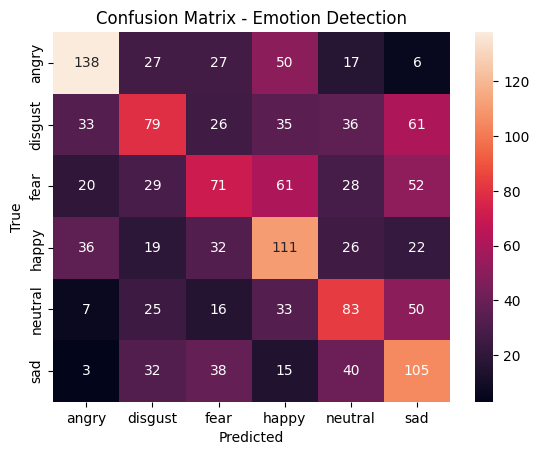


Classification Report (Emotion Detection):
              precision    recall  f1-score   support

       angry       0.58      0.52      0.55       265
     disgust       0.37      0.29      0.33       270
        fear       0.34      0.27      0.30       261
       happy       0.36      0.45      0.40       246
     neutral       0.36      0.39      0.37       214
         sad       0.35      0.45      0.40       233

    accuracy                           0.39      1489
   macro avg       0.40      0.40      0.39      1489
weighted avg       0.40      0.39      0.39      1489



In [19]:
# Confusion Matrix and F1-Score for emotions
y_true_emotion = np.argmax(y_test, axis=1)
y_pred_emotion = np.argmax(model_emotion.predict(X_test), axis=1)
cm_emotion = confusion_matrix(y_true_emotion, y_pred_emotion)
sns.heatmap(cm_emotion, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Confusion Matrix - Emotion Detection")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report (Emotion Detection):")
print(classification_report(y_true_emotion, y_pred_emotion, target_names=emotion_labels))

In [20]:
# Save model
model_emotion.save("emotion_model.h5")

# =====================================
# PHASE 2: Sentiment Mapping
# =====================================

In [21]:
print("=============================")
print("       PHASE 2: SENTIMENT MAPPING")
print("=============================")

       PHASE 2: SENTIMENT MAPPING


In [22]:
# Map emotions to sentiments
emotion_to_sentiment = {
    'happy': 'positive',
    'neutral': 'neutral',
    'sad': 'negative',
    'angry': 'negative',
    'fear': 'negative',
    'disgust': 'negative'
}
sentiment_labels = ['positive', 'neutral', 'negative']
sentiment_to_index = {s: i for i, s in enumerate(sentiment_labels)}

X_sentiment, y_sentiment = [], []

for emotion in emotion_labels:
    sentiment = emotion_to_sentiment[emotion]
    sentiment_index = sentiment_to_index[sentiment]
    emotion_folder = os.path.join(DATA_PATH, emotion)
    for file in os.listdir(emotion_folder):
        if file.endswith(".wav"):
            file_path = os.path.join(emotion_folder, file)
            y_raw, sr = librosa.load(file_path, duration=3, offset=0.5)
            mfcc = librosa.feature.mfcc(y=y_raw, sr=sr, n_mfcc=40)
            if mfcc.shape[1] < 174:
                pad_width = 174 - mfcc.shape[1]
                mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)))
            else:
                mfcc = mfcc[:, :174]
            X_sentiment.append(mfcc)
            y_sentiment.append(sentiment_index)

X_sentiment = np.array(X_sentiment)[..., np.newaxis]
y_sentiment = np.array(y_sentiment)
y_sent_cat = to_categorical(y_sentiment, num_classes=3)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sentiment, y_sent_cat, test_size=0.2, random_state=42)

In [23]:
# CNN model for sentiment classification
model_sentiment = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(40,174,1)),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

model_sentiment.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_sentiment.summary()

model_sentiment.fit(X_train_s, y_train_s, epochs=20, batch_size=32, validation_data=(X_test_s, y_test_s))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 38, 172, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,752,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,771,843 (10.57 MB)

 Trainable params: 2,771,843 (10.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 73s 376ms/step - accuracy: 0.5863 - loss: 5.3119 - val_accuracy: 0.6911 - val_loss: 0.8397
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 76s 345ms/step - accuracy: 0.6759 - loss: 0.7892 - val_accuracy: 0.6924 - val_loss: 0.7889
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 80s 334ms/step - accuracy: 0.6814 - loss: 0.7354 - val_accuracy: 0.6911 - val_loss: 0.7905
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 62s 332ms/step - accuracy: 0.6921 - loss: 0.7164 - val_accuracy: 0.6964 - val_loss: 0.7196
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 79s 314ms/step - accuracy: 0.6988 - loss: 0.6732 - val_accuracy: 0.6743 - val_loss: 0.7582
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 61s 326ms/step - accuracy: 0.7145 - loss: 0.6550 - val_accuracy: 0.7038 - val_loss: 0.7095
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 86s 350ms/step - accuracy: 0.7300 - loss: 0.6130 - val_accuracy: 0.6964 - val_loss: 0.7134
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 63s 338ms/step - accuracy: 0.7501 - loss: 0

In [24]:
# Evaluation
loss_s, acc_s = model_sentiment.evaluate(X_test_s, y_test_s)
print(f"\nSentiment Classification Accuracy: {acc_s * 100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.6547 - loss: 1.3543

Sentiment Classification Accuracy: 65.55%


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


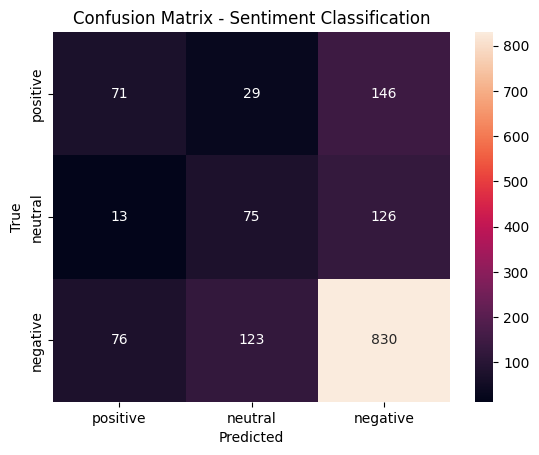


Classification Report (Sentiment Classification):
              precision    recall  f1-score   support

    positive       0.44      0.29      0.35       246
     neutral       0.33      0.35      0.34       214
    negative       0.75      0.81      0.78      1029

    accuracy                           0.66      1489
   macro avg       0.51      0.48      0.49      1489
weighted avg       0.64      0.66      0.64      1489



In [25]:
# Confusion Matrix and F1-Score for sentiment classification
y_true_sent = np.argmax(y_test_s, axis=1)
y_pred_sent = np.argmax(model_sentiment.predict(X_test_s), axis=1)
cm_sentiment = confusion_matrix(y_true_sent, y_pred_sent)
sns.heatmap(cm_sentiment, annot=True, fmt='d', xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.title("Confusion Matrix - Sentiment Classification")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report (Sentiment Classification):")
print(classification_report(y_true_sent, y_pred_sent, target_names=sentiment_labels))

In [26]:
# Save model
model_sentiment.save("sentiment_model.h5")